In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms,models
import pandas as pd
from PIL import Image
from IPython.display import display
import os

ModuleNotFoundError: No module named 'torch'

## Handling Image Input from Dataset
### Performing Operations: Dataload,Transform,Split, Compose(Normalize,Resize,Random-Flip,Crop etc.)

In [2]:
train_transform = transforms.Compose([
   transforms.RandomRotation(10),
   transforms.RandomHorizontalFlip(), #default probabily
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485,0.456,0.406],
                        [0.229,0.224,0.225])                            
])

test_transform = transforms.Compose([
   transforms.Resize(224),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize([0.485,0.456,0.406], 
                        [0.229,0.224,0.225])                                 
])

In [3]:
#For viewing original image on plt.imshow
#Denormalized
#to understand how normalization applied
inverse_normalized = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225], 
                                      std=[1/0.229,1/0.224,1/0.225])
# image_inv = inverse_normalized(NORMALIZED_IMAGE)
# plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [4]:
root = '../input/fire-smoke-and-neutral/FIRE-SMOKE-DATASET/'
#Using image folder (0f torchvision)
train_data = datasets.ImageFolder(os.path.join(root,'Train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'Test'), transform=test_transform)

torch.manual_seed(101)

#data loader
train_loader = DataLoader(train_data, batch_size=10, shuffle= True)
test_loader = DataLoader(test_data, batch_size=10,shuffle= True)

class_names = train_data.classes
print(class_names)

['Fire', 'Neutral', 'Smoke']


#### C.Name   -   Index
#### Fire    -->   0
#### Neutral -->   1
#### Smoke   -->   2

In [5]:
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

Train data size: 2700
Test data size: 300


In [6]:
for images, labels in train_loader:
      break

In [7]:
images.shape 
#output (#images per batch, #channels, dimensions)

torch.Size([10, 3, 224, 224])

Label: [2 0 2 1 0 2 2 1 0 0]
Class: Smoke Fire Smoke Neutral Fire Smoke Smoke Neutral Fire Fire


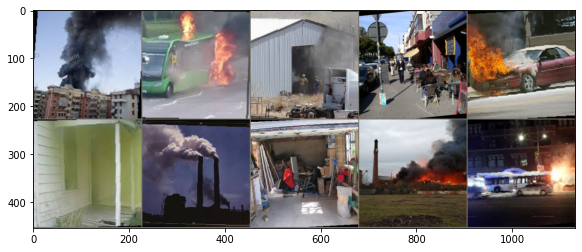

In [8]:
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow = 5)
inv_normalized = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225], 
                                      std=[1/0.229,1/0.224,1/0.225])
im_inv = inv_normalized(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [9]:
# class ConvNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # In Channels -> 3 
#         # Out channels -> 6
#         # Filter -> 3x3
#         # Stride -> 1
#         self.conv1 = nn.Conv2d(3,6,3,1)

#         # In Channels -> 6 
#         # Out channels -> 16
#         # Filter -> 3x3
#         # Stride -> 1
#         self.conv2 = nn.Conv2d(6,16,3,1)
        
#         # **Adding another convulotional layer**
#         # In Channels -> 12
#         # Out channels -> 18 >>28
#         # Filter -> 3x3
#         # Stride -> 1
#         self.conv3 = nn.Conv2d(16,28,3,1)

#         #math.floor(((((224-2)/2)-2)/2)-2)/2 = 26
#         self.fc1 = nn.Linear(26*26*28,120) 
#         self.fc2 = nn.Linear(120,84) 
#         #self.fc3 = nn.Linear(84,2)
        
#         self.fc3 = nn.Linear(84,42)
#         self.fc4 = nn.Linear(42,3)
    
#     def forward(self,X):
#         X = F.relu(self.conv1(X))
#         X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

#         X = F.relu(self.conv2(X))
#         X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
#         X = F.relu(self.conv3(X))
#         X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

#         X = X.view(-1, 26*26*28)
        
#         X = F.relu(self.fc1(X))
#         X = F.relu(self.fc2(X))
#         X = F.relu(self.fc3(X))
#         X = self.fc4(X)

#         return F.log_softmax(X, dim=1)

In [10]:
# class ConvNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # In Channels -> 3 
#         # Out channels -> 6
#         # Filter -> 3x3
#         # Stride -> 1
#         self.conv1 = nn.Conv2d(3,6,3,1)

#         # In Channels -> 6 
#         # Out channels -> 16
#         # Filter -> 3x3
#         # Stride -> 1
#         self.conv2 = nn.Conv2d(6,16,3,1)
        
#         # **Adding another convulotional layer**
#         # In Channels -> 12
#         # Out channels -> 18 >>28
#         # Filter -> 3x3
#         # Stride -> 1
#         self.conv3 = nn.Conv2d(16,26,3,1)
        
#         # **Adding another convulotional layer**
#         # In Channels -> 12
#         # Out channels -> 18 >>28
#         # Filter -> 3x3
#         # Stride -> 1
#         self.conv4 = nn.Conv2d(26,36,3,1)

        
#         #math.floor(((((((224-2)/2)-2)/2)-2)/2)-2)/2  = 12
#         self.fc1 = nn.Linear(12*12*36,120) 
#         self.fc2 = nn.Linear(120,84) 
#         self.fc3 = nn.Linear(84,42)
#         self.fc4 = nn.Linear(42,3)
    
#     def forward(self,X):
#         X = F.relu(self.conv1(X))
#         X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

#         X = F.relu(self.conv2(X))
#         X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
#         X = F.relu(self.conv3(X))
#         X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
#         X = F.relu(self.conv4(X))
#         X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        

#         X = X.view(-1, 12*12*36)
        
#         X = F.relu(self.fc1(X))
#         X = F.relu(self.fc2(X))
#         X = F.relu(self.fc3(X))
#         X = self.fc4(X)

#         return F.log_softmax(X, dim=1)

In [11]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # In Channels -> 3 
        # Out channels -> 6
        # Filter -> 3x3
        # Stride -> 1
        self.conv1 = nn.Conv2d(3,6,3,1)

        # In Channels -> 6 
        # Out channels -> 16
        # Filter -> 3x3
        # Stride -> 1
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        # **Adding another convulotional layer**
        # In Channels -> 16
        # Out channels -> 26
        # Filter -> 3x3
        # Stride -> 1
        self.conv3 = nn.Conv2d(16,26,3,1)
        
        # **Adding another convulotional layer**
        # In Channels -> 26
        # Out channels -> 36
        # Filter -> 3x3
        # Stride -> 1
        self.conv4 = nn.Conv2d(26,36,3,1)
        
        
        # **Adding another convulotional layer**
        # In Channels -> 36
        # Out channels -> 
        # Filter -> 3x3
        # Stride -> 1
        self.conv5 = nn.Conv2d(36,48,3,1)

        
    # input calculation -> Floor(((((((((224-2)/2)-2)/2)-2)/2)-2)/2)-2)/2  = 5 
    #(-2 for each filter with no padding)
    # (/2 for each pooling)
        self.fc1 = nn.Linear(5*5*48,512) 
        self.fc2 = nn.Linear(512,256) 
        self.fc3 = nn.Linear(256,80)
        self.fc4 = nn.Linear(80,3)
    
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2
        
        X = F.relu(self.conv5(X))
        X = F.max_pool2d(X,2,2) #2x2 pooling with stride 2

        X = X.view(-1, 5*5*48)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)

        return F.log_softmax(X, dim=1)

In [12]:
#Hyper parameters
SEED = 42
LEARNING_RATE = 0.001
EPOCHS = 15
MAX_BATCH_SIZE = 9999999 #unlimited (whole dataset)

torch.manual_seed(SEED)

#CNN Model
modelCNN = ConvNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr= LEARNING_RATE)

In [13]:
modelCNN

ConvNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 26, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(26, 36, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(36, 48, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=80, bias=True)
  (fc4): Linear(in_features=80, out_features=3, bias=True)
)

In [14]:
total_params = 0
for parameters in modelCNN.parameters():
  print(parameters.numel())
  total_params += parameters.numel()
print(f"Total params: {total_params} ")

162
6
864
16
3744
26
8424
36
15552
48
614400
512
131072
256
20480
80
240
3
Total params: 795921 


In [ ]:
import time
start_time = time.time()

#Limiting batch sizes
max_trn_batch = MAX_BATCH_SIZE #1800 
max_tst_batch = MAX_BATCH_SIZE #300 

train_losses = []
test_losses = []
train_correct = []
test_correct = []


for i in range(EPOCHS):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        #Limiting batch sizes for testing the model (if required)
        if b==max_trn_batch:
            break

        b+=1
        y_pred = modelCNN(X_train)
        loss = criterion(y_pred, y_train) #Loss calculation

        #Storing #correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #Backprop -> updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (b%10 ==0):
            print(f"Epoch:{i+1} Batch:{b} Loss:{loss.item():.7f} Training accuracy:{trn_corr.item()*100/(10*b):7.3f}% ")
      
    train_losses.append(loss)
    train_correct.append(trn_corr)

    # For test Set
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            if( b==max_tst_batch):
                break
            y_test_pred = modelCNN(X_test)
            predicted = torch.max(y_test_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr

    loss = criterion(y_test_pred, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Time taken: {total_time/60} mins')

Epoch:1 Batch:10 Loss:1.0796965 Training accuracy: 38.000% 
Epoch:1 Batch:20 Loss:1.0846903 Training accuracy: 37.000% 
Epoch:1 Batch:30 Loss:1.0515658 Training accuracy: 42.333% 
Epoch:1 Batch:40 Loss:0.7942196 Training accuracy: 46.250% 
Epoch:1 Batch:50 Loss:1.0778033 Training accuracy: 47.200% 
Epoch:1 Batch:60 Loss:1.2557962 Training accuracy: 49.333% 
Epoch:1 Batch:70 Loss:1.0949647 Training accuracy: 50.000% 
Epoch:1 Batch:80 Loss:0.5639508 Training accuracy: 51.500% 
Epoch:1 Batch:90 Loss:1.4279444 Training accuracy: 52.556% 
Epoch:1 Batch:100 Loss:0.9653589 Training accuracy: 53.500% 
Epoch:1 Batch:110 Loss:0.6648251 Training accuracy: 53.909% 
Epoch:1 Batch:120 Loss:0.8741069 Training accuracy: 53.750% 
Epoch:1 Batch:130 Loss:0.9027338 Training accuracy: 54.154% 
Epoch:1 Batch:140 Loss:0.7844495 Training accuracy: 53.929% 
Epoch:1 Batch:150 Loss:0.7284969 Training accuracy: 54.467% 
Epoch:1 Batch:160 Loss:0.3369734 Training accuracy: 54.438% 
Epoch:1 Batch:170 Loss:0.6354036 

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Train-Test Loss')
plt.legend();

In [ ]:
print(test_correct)
test_data_size = len(test_data)
print(f'Test accuracy: {test_correct[-1].item()*100/test_data_size:.2f}%')

In [ ]:
#Testing a single image
img_index = 190
#test data already transformed and normalized (denormalized to view them in plt.imshow)
im_test = inverse_normalized(test_data[img_index][0]) 
plt.imshow(np.transpose(im_test.numpy(), (1,2,0)))

In [ ]:
# Evaluating model with a single image from dataset
modelCNN.eval() 

with torch.no_grad():
    new_pred = modelCNN(test_data[img_index][0].view(1,3,224,224)).argmax()

print(f'Predicted class: {class_names[new_pred.item()]}')